# Generator Torque Control of a Wind Turbine using RL

This simulation addresses the issue brought up in Kathryn Johnson's thesis

"Adaptive Torque Control of Variable Speed Wind Turbines"

Her thesis highlights how much energy loss is incurred due to inaccurate models and uncertain parameters.

One of the uncertainties in her model is the air density, $\rho$. 

The aim of this simulation is to use SARSA to learn the control policy despite variations in $\rho$


In [7]:
import gym
import numpy as np
from scipy.integrate import ode
import numpy.random as rnd
import torch as pt
from importlib import reload
import matplotlib.pyplot as plt
import environment
import ODETurb

## Define classes for the neural network and for updating our learning agent

In [3]:
class nnQ(pt.nn.Module):
    """
    Here is a basic neural network for representing a policy 
    """
    
    def __init__(self,stateDim,numActions,numHiddenUnits,numLayers):
        super().__init__()
        
        
        InputLayer = [pt.nn.Linear(stateDim+numActions,numHiddenUnits),
                      pt.nn.Sigmoid()]
        
        HiddenLayers = []
        
        for _ in range(numLayers-1):
            HiddenLayers.append(pt.nn.Linear(numHiddenUnits,numHiddenUnits))
            HiddenLayers.append(pt.nn.ReLU())
            
        OutputLayer = [pt.nn.Linear(numHiddenUnits,1)]
        
        AllLayers = InputLayer + HiddenLayers + OutputLayer
        self.net = pt.nn.Sequential(*AllLayers)
        
        self.numActions = numActions
        
    def forward(self,x,a):
        x = pt.tensor(x,dtype=pt.float32) # feature
        a = pt.tensor(a, dtype=pt.int64)  # parametesw
        b = pt.nn.functional.one_hot(a,self.numActions)
        c = b.float().detach()
        y = pt.cat([x,c])
        
        return self.net(y)
        
    
class sarsaAgent:
    def __init__(self,stateDim ,numActions,numHiddenUnits,numLayers,
                epsilon=0.1,gamma=.9,alpha=.1):
        # These are the parameters
        self.Q = nnQ(stateDim,numActions,numHiddenUnits,numLayers)
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.numActions = numActions
        self.s_last = None
       
    def action(self,x):
        # This is an epsilon greedy selection (can do max also)
        # Whichever has the highest Q, perform that action
        if rnd.rand() < self.epsilon:
            a = rnd.randint(numActions)
        else:
            qBest = -np.inf
            a = rnd.randint(numActions)
            for aTest in range(self.numActions):
                qTest = self.Q(x,aTest).detach().numpy()[0]
                if qTest > qBest:
                    qBest = qTest
                    a = aTest
        return a
    
    def update(self,s,a,r,s_next,done):
        
        # Compute the TD error, if there is enough data
        update = True
        if done:
            Q_cur = self.Q(s,a).detach().numpy()[0]
            delta = r - Q_cur
            self.s_last = None
            Q_diff = self.Q(s,a)
        elif self.s_last is not None:
            Q_next = self.Q(s,a).detach().numpy()[0]
            Q_cur = self.Q(self.s_last,self.a_last).detach().numpy()[0]
            delta = self.r_last + self.gamma * Q_next - Q_cur
            Q_diff = self.Q(self.s_last,self.a_last)
        else:
            update = False
            
        # Update the parameter via the semi-gradient method
        if update:
            self.Q.zero_grad()
            Q_diff.backward()
            for p in self.Q.parameters():
                p.data.add_(self.alpha*delta,p.grad.data)
            
            
        
        if not done:
            self.s_last = np.copy(s)
            self.a_last = np.copy(a)
            self.r_last = np.copy(r)



## SARSA with NN

The below algorithm is the actual SARSA algorithm. sarsaAgent (defined above) spits out the action required such that power is maximized and such that states are in a constrained set. 

In RL longo,

1. action: Generator Torque

2. rewards: Electrical power output of turbine

3. done: if too fast

4. next state: generated using the ODEs in ODEturb.py

In [ ]:
numActions = 10
Actions = np.linspace(0,1,numActions)

# This is our learning agent
gamma = .95
agent = sarsaAgent(4,numActions,10,1,epsilon=5e-2,gamma=gamma,alpha=1e-2)
maxSteps = 1e5

R = []
UpTime = []

step = 0
ep = 0
while step < maxSteps:
    ep += 1
    x = environment.reset() # initialize the state
    C = 0.  
    
    done = False
    t = 1
    while not done:
        t += 1 
        step += 1
        a = agent.action(x)
        u = Actions[a];
        
        x_next,c, done = environment.step(u,x)
         
        C += (1./t)*(c-C)
        agent.update(x,a,c,x_next,done)
        x = x_next
         

        if done:
            break
            
        if step >= maxSteps:
            break
            
        
        R.append(C)
        
    print('Episode:',ep,'Total Steps:',step,', Ave. Reward/Power :',c,', Episode Length:',t-1)

## Plots

Let us stop training and use this controller. 

Also, what is better; the traditional $k \omega^2 $ law or our RL controller?

Text(0.5, 1.0, 'GenTorque Control with Uncertain Air Density')

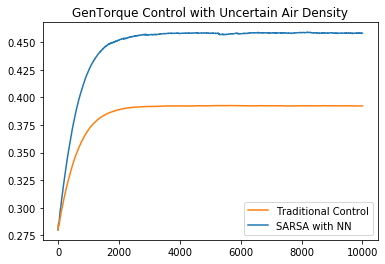

In [5]:
# Plot the power output of the turbine with trained controller from above

Power = []
x = np.array([1,1,1,1])
for i in range(10000):
    a = agent.action(x);
    u = Actions[a];
    x_next,c,done = environment.step(u,x);
    Power.append(c)
    x = np.copy(x_next)



# Plot the power output of the turbine with traditional control law

Kopt = .28;
Power_trad = []
x_trad = np.array([1,1,1,1])
for i in range(10000):
    u_trad = Kopt*x[2]**2;
    x_next_trad,c_trad,done = environment.step(u_trad,x_trad)
    Power_trad.append(c_trad)
    x_trad = np.copy(x_next_trad)
    

line_up, = plt.plot(Power)
line_down, = plt.plot(Power_trad)

plt.legend([line_down, line_up], ['Traditional Control', 'SARSA with NN'])
plt.title('GenTorque Control with Uncertain Air Density');